<a href="https://colab.research.google.com/github/MalakSeddik/Account/blob/master/Driver_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **State Farm Distracted Driver Detection Project**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## **1. Obtaining and Organizing the Dataset**

### **1.1. Download Dataset from kaggle**

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [35]:
path = "/content/state_farm"

print("Path to dataset files:", path)

Path to dataset files: /content/state_farm


In [28]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!kaggle datasets download -d rightway11/state-farm-distracted-driver-detection -p /content

Dataset URL: https://www.kaggle.com/datasets/rightway11/state-farm-distracted-driver-detection
License(s): unknown
 93% 484M/522M [00:06<00:00, 82.5MB/s]
100% 522M/522M [00:06<00:00, 86.6MB/s]


In [36]:
import pandas as pd
import os

# Load the dataset from the correct path, assuming 'path' is defined in a previous cell.
df = pd.read_csv(os.path.join(path, 'driver_imgs_list.csv'))
df.head()

subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg

### **1.2. Data Visualization**

In [37]:
import os
dataset = pd.read_csv(os.path.join(path, 'driver_imgs_list.csv'))
dataset.head(5)

subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg

<Axes: xlabel='classname', ylabel='count'>

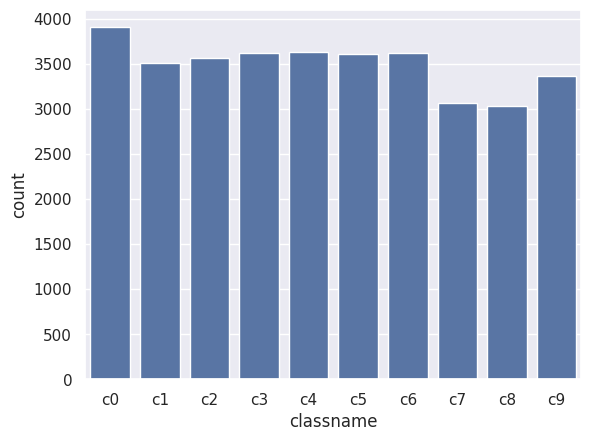

In [38]:
import seaborn as sns

# Number of images by category
sns.set_theme(style="darkgrid")
sns.countplot(x = 'classname', data=dataset)

###**1.3. Organizing the Dataset**

In [39]:
!pip install split-folders

In [40]:
!ls /content


kaggle.json  state_farm
sample_data  state-farm-distracted-driver-detection.zip


In [41]:
!ls -R /content


/content:
kaggle.json  state_farm
sample_data  state-farm-distracted-driver-detection.zip

/content/sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md

/content/state_farm:
driver_imgs_list.csv  imgs  sample_submission.csv

/content/state_farm/imgs:
test  train

/content/state_farm/imgs/test:
img_100015.jpg	img_26740.jpg  img_4447.jpg   img_62871.jpg  img_81943.jpg
img_100027.jpg	img_26767.jpg  img_44500.jpg  img_62882.jpg  img_81963.jpg
img_100046.jpg	img_26768.jpg  img_4450.jpg   img_62894.jpg  img_81974.jpg
img_100057.jpg	img_26790.jpg  img_44510.jpg  img_62917.jpg  img_82005.jpg
img_100061.jpg	img_26807.jpg  img_44537.jpg  img_62930.jpg  img_82068.jpg
img_100108.jpg	img_26841.jpg  img_44540.jpg  img_62936.jpg  img_82071.jpg
img_100113.jpg	img_26914.jpg  img_44544.jpg  img_62946.jpg  img_82074.jpg
img_100116.jpg	img_26915.jpg  img_44549.jpg  img_62970.jpg  img_82115.jpg
img_10012.jpg	img_26934.

In [42]:
!ls -R /content


/content:
kaggle.json  state_farm
sample_data  state-farm-distracted-driver-detection.zip

/content/sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md

/content/state_farm:
driver_imgs_list.csv  imgs  sample_submission.csv

/content/state_farm/imgs:
test  train

/content/state_farm/imgs/test:
img_100015.jpg	img_26740.jpg  img_4447.jpg   img_62871.jpg  img_81943.jpg
img_100027.jpg	img_26767.jpg  img_44500.jpg  img_62882.jpg  img_81963.jpg
img_100046.jpg	img_26768.jpg  img_4450.jpg   img_62894.jpg  img_81974.jpg
img_100057.jpg	img_26790.jpg  img_44510.jpg  img_62917.jpg  img_82005.jpg
img_100061.jpg	img_26807.jpg  img_44537.jpg  img_62930.jpg  img_82068.jpg
img_100108.jpg	img_26841.jpg  img_44540.jpg  img_62936.jpg  img_82071.jpg
img_100113.jpg	img_26914.jpg  img_44544.jpg  img_62946.jpg  img_82074.jpg
img_100116.jpg	img_26915.jpg  img_44549.jpg  img_62970.jpg  img_82115.jpg
img_10012.jpg	img_26934.

In [43]:
import splitfolders

data_dir = '/content/state_farm/imgs/train'
splitfolders.ratio(data_dir, output="train_split", ratio=(0.8, 0.1, 0.1))

# Check everything
!ls /content/train_split
!ls -R /content/train_split/train


Copying files: 17462 files [00:08, 2114.16 files/s]


test  train  val
/content/train_split/train:
c0  c1	c2  c3	c4  c5	c6  c7	c8  c9

/content/train_split/train/c0:
img_10003.jpg	img_26802.jpg  img_4399.jpg   img_61905.jpg  img_81103.jpg
img_100050.jpg	img_26907.jpg  img_4400.jpg   img_62023.jpg  img_81124.jpg
img_100074.jpg	img_26926.jpg  img_44030.jpg  img_62053.jpg  img_81192.jpg
img_100145.jpg	img_2695.jpg   img_44061.jpg  img_62061.jpg  img_81194.jpg
img_100257.jpg	img_26975.jpg  img_44073.jpg  img_62066.jpg  img_81205.jpg
img_100337.jpg	img_27005.jpg  img_44083.jpg  img_62129.jpg  img_8122.jpg
img_100456.jpg	img_27041.jpg  img_44090.jpg  img_62207.jpg  img_81279.jpg
img_10053.jpg	img_2704.jpg   img_44227.jpg  img_62307.jpg  img_8128.jpg
img_100542.jpg	img_27079.jpg  img_44280.jpg  img_62376.jpg  img_81332.jpg
img_100598.jpg	img_27110.jpg  img_44281.jpg  img_6240.jpg   img_81383.jpg
img_100605.jpg	img_27134.jpg  img_44388.jpg  img_62484.jpg  img_81441.jpg
img_100656.jpg	img_27276.jpg  img_44419.jpg  img_62538.jpg  img_81502.jpg
img_

In [44]:
display(dataset)

subject classname            img
0        p012        c0  img_10206.jpg
1        p012        c0  img_27079.jpg
2        p012        c0  img_50749.jpg
3        p012        c0  img_97089.jpg
4        p012        c0  img_37741.jpg
...       ...       ...            ...
34919    p075        c9  img_15827.jpg
34920    p075        c9  img_16688.jpg
34921    p075        c9  img_64532.jpg
34922    p075        c9   img_7918.jpg
34923    p075        c9  img_84918.jpg

[34924 rows x 3 columns]

## **2. Image Augmentation**

In [46]:
# Calculate means and stds of the trainset and normalize

output_dir = '/content/train_split'

train_data = torchvision.datasets.ImageFolder(root = output_dir+'/train', transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.3123, 0.3778, 0.3705])
Calculated stds: tensor([0.2849, 0.3299, 0.3302])


In [47]:
data_augmentation = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        #transforms.Normalize(mean = means, std = stds),
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        #transforms.Normalize(mean = means, std = stds),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'cust_test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

## **3. Reading the Dataset**

In [48]:
Batch_Size = 16
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(output_dir, x),
                                                      data_augmentation[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,shuffle=True,
                                              drop_last=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###**3.1. Images from Original Data**

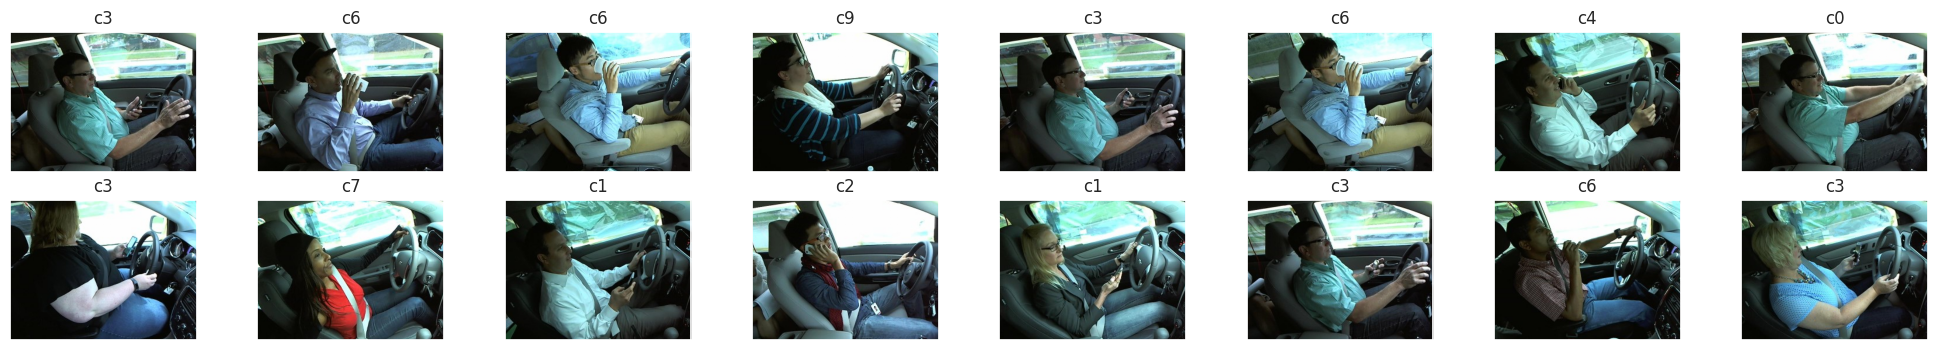

In [49]:
# Visualize some sample data from the original dataset

images, labels = next(iter(dataloaders['test']))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow((np.transpose(images[idx], (1, 2, 0))))
    ax.set_title(class_names[labels[idx]])

###**3.2. Images after Augmentation**

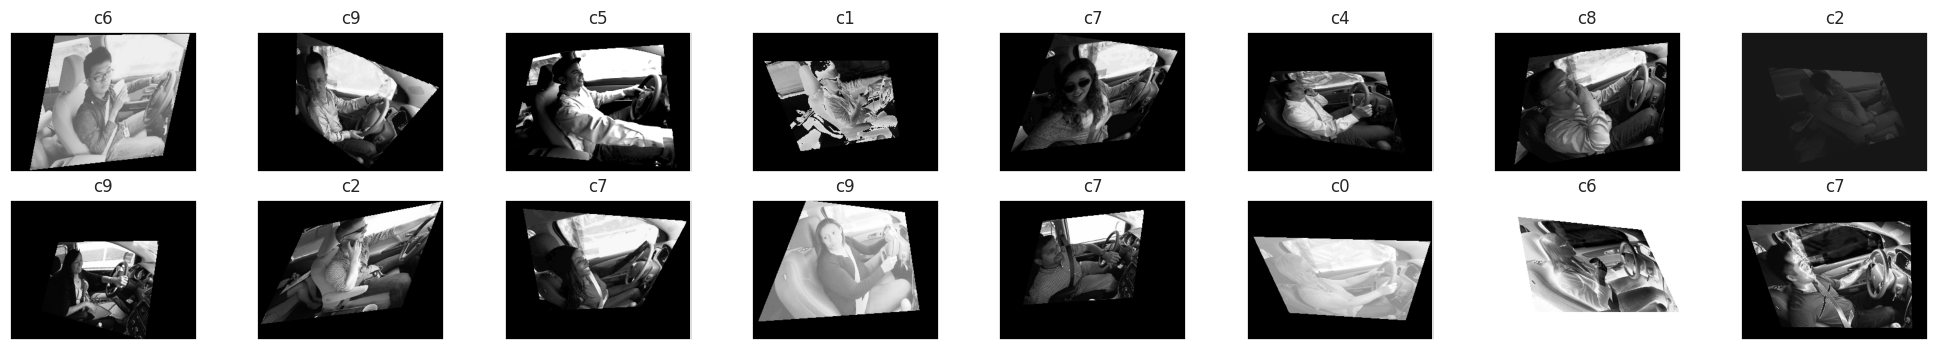

In [50]:
# Visualize some sample data after Augmentation

images, labels = next(iter(dataloaders['train']))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow((np.transpose(images[idx], (1, 2, 0))))
    ax.set_title(class_names[labels[idx]])

## **4. Defining Models**

In [51]:
!pip install torchinfo

In [64]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [65]:
img_size = (224, 224)
batch_size = 32

train_dir = "/content/train_split/train"
val_dir   = "/content/train_split/val"
test_dir  = "/content/train_split/test"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 13965 files belonging to 10 classes.
Found 1742 files belonging to 10 classes.
Found 1755 files belonging to 10 classes.


In [67]:
# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset   = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset  = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))


In [70]:
# Get class names before mapping
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
class_names = train_dataset.class_names  # Save class names

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 13965 files belonging to 10 classes.
Found 1742 files belonging to 10 classes.
Found 1755 files belonging to 10 classes.


In [71]:
num_classes = len(class_names)

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### **4.2. DenseNet**

In [ ]:
from torchinfo import summary

Dense = torchvision.models.densenet121(weights='DEFAULT').to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in Dense.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
Dense.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1024,
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(Dense,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Sequential (features)                       [16, 3, 224, 224]    [16, 1024, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (norm0)                    [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [16, 64, 56, 56]     [16, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [16, 64, 56, 56]     [16, 32, 56, 

In [ ]:
## Model inItialization
criterion_Dense = nn.CrossEntropyLoss()
optimizer_Dense = optim.SGD(Dense.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler_Dense = lr_scheduler.StepLR(optimizer_Dense, step_size=7, gamma=0.1)

### **4.3. EfficientNet**


In [ ]:
from torchinfo import summary

EfficientNet_B0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
EfficientNet_B0 = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_weights).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in EfficientNet_B0.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
EfficientNet_B0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(EfficientNet_B0,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]   [16, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [16, 32, 112, 112]   [16, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 32, 112, 112]   [16, 

In [ ]:
## Model inItialization
criterion_EfficientNet_B0 = nn.CrossEntropyLoss()
optimizer_EfficientNet_B0 = optim.SGD(EfficientNet_B0.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler_EfficientNet_B0 = lr_scheduler.StepLR(optimizer_EfficientNet_B0, step_size=7, gamma=0.1)

### **4.4. MobileNet V3**

In [52]:
from torchinfo import summary

MobileNet_V3 = torchvision.models.mobilenet_v3_large(weights='DEFAULT').to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in MobileNet_V3.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
MobileNet_V3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=960,
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(MobileNet_V3,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 71.3MB/s]


KeyboardInterrupt: 

In [ ]:
## Model inItialization
criterion_MobileNet_V3 = nn.CrossEntropyLoss()
optimizer_MobileNet_V3 = optim.SGD(MobileNet_V3.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler_MobileNet_V3 = lr_scheduler.StepLR(optimizer_MobileNet_V3, step_size=7, gamma=0.1)

## **5. Training Models**

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [ ]:
def train_model(args):
    """
    Train the Neural Networks
    Args:
        args, dictionary containing all the arguments used in training
            args.model: class name of the model
            args.num_epochs(int): number of epochs
            args.batch_size(int): batch size
            args.criterion: criterion used in training
            args.optimizer: optimizer used in training
            args.scheduler: scheduler used in training
            args.save_checkpoints(bool): save checkpoints
            args.experiment_name(str): experiment name, used as folder name
        net, neural net to be trained
    Return:
        The best neural net in the training
    """
    start_time = time.time()

    save_dir = "output/" + args.experiment_name + "/"

    # if path does not exist, create one
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    best_weight = copy.deepcopy(args.model.state_dict())
    best_acc = 0.0

    train_accs, train_losses = [], []
    val_accs, val_losses = [], []

    for epoch in range(args.num_epochs):
        epoch_start = time.time()
        print(f'Epoch {epoch}/{args.num_epochs - 1}', end=': ')

        for phase in ['train', 'val']:
            if phase == 'train':
                args.model.train() # training mode
            else:
                args.model.eval()  # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                args.optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = args.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = args.criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        args.optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} loss: {epoch_loss:.4f} {phase} acc: {epoch_acc:.4f}', end=', ')

            if phase == 'train':
                args.scheduler.step()
                train_accs.append(epoch_acc.cpu().detach())
                train_losses.append(epoch_loss)
            else:
                val_accs.append(epoch_acc.cpu().detach())
                val_losses.append(epoch_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(args.model.state_dict())

            # save checkpoints every epoch
            if args.save_checkpoints:
                checkpoints_dir = save_dir + f"model_{args.experiment_name}_bs_{args.batch_size}_epoch_{epoch}"
                torch.save(args.model.state_dict(), checkpoints_dir)

        epoch_dur = round(time.time() - epoch_start,2)
        print(f'Epoch time:  {epoch_dur // 60:.0f}m {epoch_dur % 60:.0f}s')

    time_elapsed = time.time() - start_time
    print()
    print('-' * 20)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # save accuracy and loss
    if args.save_checkpoints:
        np.savetxt(save_dir + f"model_{args.experiment_name}_train_acc.csv", train_accs)
        np.savetxt(save_dir + f"model_{args.experiment_name}_train_loss.csv", train_losses)
        np.savetxt(save_dir + f"model_{args.experiment_name}_val_acc.csv", val_accs)
        np.savetxt(save_dir + f"model_{args.experiment_name}_val_loss.csv", val_losses)

    # plot traininng curve
    train_accs, val_accs = np.array(train_accs), np.array(val_accs)
    train_losses, val_losses = np.array(train_losses), np.array(val_losses)

    plt.plot(np.arange(args.num_epochs, step=1), train_losses, label='Train loss')
    plt.plot(np.arange(args.num_epochs, step=1), train_accs, label='Train acc')
    plt.plot(np.arange(args.num_epochs, step=1), val_accs, label='Val acc')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # load and save the best model weights
    checkpoints_dir = save_dir + f"model_{args.experiment_name}_bs_{args.batch_size}_best_model"
    torch.save(args.model.state_dict(best_model_wts), checkpoints_dir)
    args.model.load_state_dict(best_model_wts)

    return args.model

### **5.1. DenseNet**

Epoch 0/4: train loss: 0.6986 train acc: 0.7629, val loss: 0.2699 val acc: 0.9101, Epoch time:  27m 8s
Epoch 1/4: train loss: 0.2216 train acc: 0.9306, val loss: 0.2088 val acc: 0.9356, Epoch time:  27m 8s
Epoch 2/4: train loss: 0.1403 train acc: 0.9583, val loss: 0.2461 val acc: 0.9204, Epoch time:  27m 9s
Epoch 3/4: train loss: 0.1056 train acc: 0.9677, val loss: 0.0827 val acc: 0.9687, Epoch time:  27m 10s
Epoch 4/4: train loss: 0.0950 train acc: 0.9702, val loss: 0.0731 val acc: 0.9665, Epoch time:  27m 10s

--------------------
Training complete in 135m 46s
Best val Acc: 0.968708


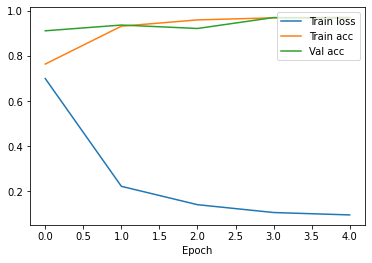

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [ ]:
Dense_args = AttrDict()

## Args setting
Dense_args_dict = {
    'model': Dense,
    'num_epochs': 5,
    'batch_size': 16,
    'criterion': criterion_Dense,
    'optimizer': optimizer_Dense,
    'scheduler': exp_lr_scheduler_Dense,
    'save_checkpoints': True,
    'experiment_name': "Dense"
}

## Training process
Dense_args.update(Dense_args_dict)
Dense_output_model = train_model(Dense_args)

### **5.2. EfficientNet B0**

Epoch 0/4: train loss: 0.7727 train acc: 0.7403, val loss: 0.1628 val acc: 0.9414, Epoch time:  17m 15s
Epoch 1/4: train loss: 0.1580 train acc: 0.9489, val loss: 0.0787 val acc: 0.9696, Epoch time:  17m 2s
Epoch 2/4: train loss: 0.1058 train acc: 0.9672, val loss: 0.0529 val acc: 0.9790, Epoch time:  17m 2s
Epoch 3/4: train loss: 0.0709 train acc: 0.9775, val loss: 0.0511 val acc: 0.9750, Epoch time:  17m 3s
Epoch 4/4: train loss: 0.0620 train acc: 0.9802, val loss: 0.0280 val acc: 0.9866, Epoch time:  16m 59s

--------------------
Training complete in 85m 22s
Best val Acc: 0.986589


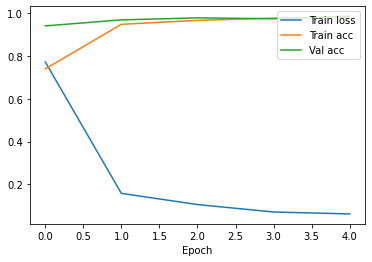

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [ ]:
EfficientNet_B0_args = AttrDict()

## Args setting
EfficientNet_B0_args_dict = {
    'model': EfficientNet_B0,
    'num_epochs': 5,
    'batch_size': 16,
    'criterion': criterion_EfficientNet_B0,
    'optimizer': optimizer_EfficientNet_B0,
    'scheduler': exp_lr_scheduler_EfficientNet_B0,
    'save_checkpoints': True,
    'experiment_name': "EfficientNet_B0"
}

## Training process
EfficientNet_B0_args.update(EfficientNet_B0_args_dict)
EfficientNet_B0_output_model = train_model(EfficientNet_B0_args)

###**5.3. MobileNet V3**

Epoch 0/4: train loss: 1.0261 train acc: 0.6386, val loss: 0.5383 val acc: 0.8207, Epoch time:  13m 19s
Epoch 1/4: train loss: 0.1956 train acc: 0.9374, val loss: 0.2144 val acc: 0.9267, Epoch time:  13m 15s
Epoch 2/4: train loss: 0.1138 train acc: 0.9649, val loss: 0.1665 val acc: 0.9401, Epoch time:  13m 3s
Epoch 3/4: train loss: 0.0855 train acc: 0.9736, val loss: 0.1346 val acc: 0.9526, Epoch time:  13m 6s
Epoch 4/4: train loss: 0.0666 train acc: 0.9803, val loss: 0.0646 val acc: 0.9736, Epoch time:  13m 3s

--------------------
Training complete in 65m 47s
Best val Acc: 0.973625


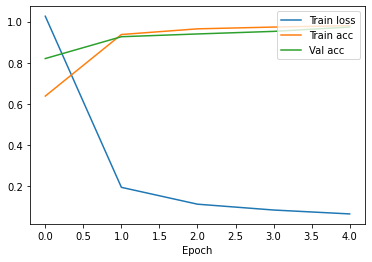

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [ ]:
MobileNet_V3_args = AttrDict()

## Args setting
MobileNet_V3_args_dict = {
    'model': MobileNet_V3,
    'num_epochs': 5,
    'batch_size': 16,
    'criterion': criterion_MobileNet_V3,
    'optimizer': optimizer_MobileNet_V3,
    'scheduler': exp_lr_scheduler_MobileNet_V3,
    'save_checkpoints': True,
    'experiment_name': "MobileNet_V3"
}

## Training process
MobileNet_V3_args.update(MobileNet_V3_args_dict)
MobileNet_V3_output_model = train_model(MobileNet_V3_args)

## **6. Evaluation on Testset**

### **6.1. Test Accuracy**

In [ ]:
def evaluate_model(model, loader, size):
    """
    Evaluate model performance on testset
    """
    model.eval()
    model.to(device)

    test_acc = 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        test_acc += torch.sum(preds == labels.data).item()

    test_acc = test_acc / size

    return test_acc

In [ ]:
Dense_model_state = torch.load('/content/model_Dense_bs_16_best_model')
Dense.load_state_dict(Dense_model_state)
Dense_acc = evaluate_model(Dense, dataloaders['test'], dataset_sizes['test'])
print('Test acc: ', Dense_acc)

Test acc:  0.8996893031513538


In [ ]:
EfficientNet_B0_model_state = torch.load('/content/model_EfficientNet_B0_bs_16_best_model')
EfficientNet_B0.load_state_dict(EfficientNet_B0_model_state)
EfficientNet_B0_acc = evaluate_model(EfficientNet_B0, dataloaders['test'], dataset_sizes['test'])
print('Test acc: ', EfficientNet_B0_acc)

Test acc:  0.9684864624944518


In [ ]:
MobileNet_V3_model_state = torch.load('/content/model_MobileNet_V3_bs_16_best_model')
MobileNet_V3.load_state_dict(MobileNet_V3_model_state)
MobileNet_V3_acc = evaluate_model(MobileNet_V3, dataloaders['test'], dataset_sizes['test'])
print('Test acc: ', MobileNet_V3_acc)

Test acc:  0.9467376830892144


### **6.2. Confusion Matrix**

In [ ]:
def get_predictions(model, loader):
    """
    Get predictions on testset
    """
    model.eval()
    model.to(device)

    labels_list = []
    probs_list = []
    pred_labels = []

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            y_prob = F.softmax(outputs, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            labels_list.append(labels.cpu())
            probs_list.append(y_prob.cpu())
            pred_labels.append(top_pred.cpu())

    labels_list = torch.cat(labels_list, dim = 0)
    probs_list = torch.cat(probs_list, dim = 0)
    pred_labels = torch.cat(pred_labels, dim = 0)


    return labels_list, probs_list, pred_labels

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)

In [ ]:
Dense_labels, Dense_probs, Dense_pred_labels = get_predictions(Dense, dataloaders['test'])
plot_confusion_matrix(Dense_labels, Dense_pred_labels, class_names)

In [ ]:
EfficientNet_B0_labels, EfficientNet_B0_probs, EfficientNet_B0_pred_labels = get_predictions(EfficientNet_B0, dataloaders['test'])
plot_confusion_matrix(EfficientNet_B0_labels, EfficientNet_B0_pred_labels, class_names)

In [ ]:
MobileNet_V3_labels, MobileNet_V3_probs, MobileNet_V3_pred_labels = get_predictions(MobileNet_V3, dataloaders['test'])
plot_confusion_matrix(MobileNet_V3_labels, MobileNet_V3_pred_labels, class_names)

## **7. Ensemble Models**

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.num_models = len(models)
        self.models = models
        self.weights = torch.ones(self.num_models,10)

In [ ]:
ensemble3 = EnsembleModel([Dense, MobileNet_V3, EfficientNet_B0])

In [ ]:
def ensemble_pred_majority(model, loader):
    """
    majority vote
    """
    model.to(device)
    for net in model.models:
        net.eval()

    labels_list = []
    pred_labels = []

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            out = model.models[0](inputs)
            _, pred = torch.max(out, 1)
            pred = pred[None, :]    # add one dimension

            for i in range(1, model.num_models):
                out = model.models[i](inputs)
                _, new_pred = torch.max(out, 1)
                new_pred = new_pred[None, :]
                pred = torch.cat((pred, new_pred), dim=0)

            pred = pred.cpu().detach()
            pred = torch.tensor(mode(pred)[0])

            labels_list.append(labels.cpu())
            pred_labels.append(pred.cpu())

    labels_list = torch.cat(labels_list, dim = 0)
    pred_labels = torch.cat(pred_labels, dim = 0)


    return labels_list, torch.flatten(pred_labels)

In [ ]:
def ensemble_pred_avg(model, loader):
    """
    average likelihood
    """
    model.to(device)
    for net in model.models:
        net.eval()

    labels_list = []
    pred_labels = []

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            out_sum = torch.zeros((len(inputs), 10)).to(device)
            for i in range(model.num_models):
                out = model.models[i](inputs)
                out_sum += out
                _, pred = torch.max(out_sum, 1)

            labels_list.append(labels.cpu())
            pred_labels.append(pred.cpu())

    labels_list = torch.cat(labels_list, dim = 0)
    pred_labels = torch.cat(pred_labels, dim = 0)


    return labels_list, torch.flatten(pred_labels)

In [ ]:
def ensemble_weighted_pred(model, x):
    """
    weighted majority vote
    """
    model.to(device)
    for net in model.models:
        net.eval()
    x = x.to(device)
    data_size = len(x)
    multi_class_pred = torch.zeros((model.num_models, data_size, 10)).to(device)
    multi_class_idx = torch.zeros((model.num_models, data_size)).to(device)

    with torch.set_grad_enabled(False):
        for i in range(model.num_models):
            out = model.models[i](x)
            _, pred = torch.max(out, 1)
            multi_class_idx[i] = pred
            for single_pred, idx in zip(multi_class_pred[i], pred):
                single_pred[idx] = model.weights[i][idx]

    weight_sum = torch.sum(multi_class_pred, dim=0)
    _, final_pred = torch.max(weight_sum, 1)

    return final_pred, multi_class_idx

In [ ]:
majority_labels, majority_pred_labels = ensemble_pred_majority(ensemble3, dataloaders['test'])
majority_acc = int(torch.sum(majority_labels == torch.flatten(majority_pred_labels))) / majority_labels.size()[0]
print('Test acc: ', majority_acc)

Test acc:  0.9691964285714286


In [ ]:
avg_labels, avg_pred_labels = ensemble_pred_avg(ensemble3, dataloaders['test'])
avg_acc = int(torch.sum(avg_labels == torch.flatten(avg_pred_labels))) / avg_labels.size()[0]
print('Test acc: ', avg_acc)

Test acc:  0.9799107142857143


## **8. Evaluation on Customized Dataset**

In [ ]:
!unzip /content/Video_Frames_Balanced.zip

In [ ]:
Batch_Size = 16
cust_output_dir = '/content'
cust_image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(cust_output_dir, x),
                                                      data_augmentation[x]) for x in ['cust_test']}
cust_dataloaders = {x: torch.utils.data.DataLoader(cust_image_datasets[x], batch_size=Batch_Size,shuffle=True,
                                              drop_last=True) for x in ['cust_test']}
cust_dataset_sizes = {x: len(cust_image_datasets[x]) for x in ['cust_test']}
cust_class_names = cust_image_datasets['cust_test'].classes

In [ ]:
Dense_acc = evaluate_model(Dense, cust_dataloaders['cust_test'],
                           cust_dataset_sizes['cust_test'])
print('Test acc: ', Dense_acc)

Test acc:  0.68


In [ ]:
EfficientNet_B0_acc = evaluate_model(EfficientNet_B0, cust_dataloaders['cust_test'],
                                     cust_dataset_sizes['cust_test'])
print('Test acc: ', EfficientNet_B0_acc)

Test acc:  0.84


In [ ]:
MobileNet_V3_acc = evaluate_model(MobileNet_V3, cust_dataloaders['cust_test'],
                                  cust_dataset_sizes['cust_test'])
print('Test acc: ', MobileNet_V3_acc)

Test acc:  0.8775


In [ ]:
majority_labels, majority_pred_labels = ensemble_pred_majority(ensemble3, cust_dataloaders['cust_test'])
majority_acc = int(torch.sum(majority_labels == torch.flatten(majority_pred_labels))) / majority_labels.size()[0]
print('Test acc: ', majority_acc)

Test acc:  0.9825


In [ ]:
avg_labels, avg_pred_labels = ensemble_pred_avg(ensemble3, cust_dataloaders['cust_test'])
avg_acc = int(torch.sum(avg_labels == torch.flatten(avg_pred_labels))) / avg_labels.size()[0]
print('Test acc: ', avg_acc)

Test acc:  0.93


##**9. Demonstration**

In [ ]:
# display our demonstration video
from IPython.display import HTML
from base64 import b64encode
mp4 = open('Video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## **10. References**

`[1] Krizhevsky, A. (2014). One weird trick for parallelizing convolutional neural networks. arXiv preprint arXiv:1404.5997.`

`[2] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). Mobilenetv2: Inverted residuals and linear bottlenecks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4510-4520).`

`[3] Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated residual transformations for deep neural networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1492-1500).`

`[4] Howard, A., Sandler, M., Chu, G., Chen, L. C., Chen, B., Tan, M., ... & Adam, H. (2019). Searching for mobilenetv3. In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 1314-1324).`

`[5] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.`

`[6] Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A. (2015). Going deeper with convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1-9).`

In [ ]:
%%shell
jupyter nbconvert --to html /content/State_Farm_Distracted_Driver_Detection.ipynb

[NbConvertApp] Converting notebook /content/State_Farm_Distracted_Driver_Detection.ipynb to html
[NbConvertApp] Writing 1514490 bytes to /content/State_Farm_Distracted_Driver_Detection.html
